# -------- Correlation Between News and Stock Market--------

In [188]:
import pandas as pd
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import numpy as np
import matplotlib.pyplot as plt

#  Download VADER lexicon (run this once)

In [189]:
try:
    nltk.data.find('sentiment/vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kumsam\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# --- Classes for OOP Implementation ---

In [190]:
class DataLoader:
    """
    Handles loading news and a single stock data file from CSVs.
    """
    def __init__(self, news_filepath, stock_filepath):
        self.news_filepath = news_filepath
        self.stock_filepath = stock_filepath

    def load_data(self):
        """Loads news and single stock data from specified filepaths."""
        try:
            news_df = pd.read_csv(self.news_filepath)
            stock_df = pd.read_csv(self.stock_filepath)
            print(f"Loaded: {self.stock_filepath}")
        except FileNotFoundError as e:
            raise FileNotFoundError(
                f"File not found: {e.filename}. Please ensure the file path is correct."
            ) from e

        # Convert Date columns to datetime
        news_df['Date'] = pd.to_datetime(news_df['Date'], errors='coerce')
        stock_df['Date'] = pd.to_datetime(stock_df['Date'], errors='coerce')

        # Remove timezone if present
        news_df['Date'] = news_df['Date'].dt.tz_localize(None)
        stock_df['Date'] = stock_df['Date'].dt.tz_localize(None)

        # Drop rows with bad dates
        news_df.dropna(subset=['Date'], inplace=True)
        stock_df.dropna(subset=['Date'], inplace=True)

        return news_df, stock_df


# ------- Market Data Processor -------

In [191]:
class MarketDataProcessor:
    """
    Processes raw market data, aligning dates and calculating stock returns.
    """
    def __init__(self, news_df, stock_df):
        self.news_df = news_df
        self.stock_df = stock_df
        self.processed_df = None

    def align_and_merge_data(self):
        """Aligns news and stock data by date and merges them.""" 
        # Normalize the Date columns to remove time info (set time to midnight)
        self.news_df['Date'] = self.news_df['Date'].dt.normalize()
        self.stock_df['Date'] = self.stock_df['Date'].dt.normalize()
        
        # Aggregate news headlines by date
        daily_news_agg = self.news_df.groupby('Date').agg({'Headline': lambda x: ' '.join(x)}).reset_index()
        
        # Merge datasets on Date, keeping all dates from both if available
        merged_df = pd.merge(self.stock_df, daily_news_agg, on='Date', how='outer')
        merged_df.sort_values(by='Date', inplace=True)
        merged_df.set_index('Date', inplace=True)
        
        # Fill missing headlines for dates where there's stock data but no news
        merged_df['Headline'] = merged_df['Headline'].fillna('')
        self.processed_df = merged_df
        print("\nDate alignment and merging complete.")
        return self.processed_df

    def calculate_daily_returns(self):
        """Calculates daily percentage change in stock closing prices."""
        if self.processed_df is None:
            raise ValueError("Data not aligned. Run align_and_merge_data() first.")
        
        # Ensure 'Close' column is numeric, coercing errors to NaN
        self.processed_df['Close'] = pd.to_numeric(self.processed_df['Close'], errors='coerce')
        self.processed_df['Daily_Return'] = self.processed_df['Close'].pct_change(fill_method=None) * 100

        self.processed_df.dropna(subset=['Daily_Return'], inplace=True) # Drop first row (NaN)
        print("Daily stock returns calculated.")
        return self.processed_df


# ------- Sentiment Analyzer ------

In [192]:
class SentimentAnalyzer:
    """
    Performs sentiment analysis on text data using TextBlob and VADER.
    """
    def __init__(self):
        self.vader_analyzer = SentimentIntensityAnalyzer()

    def _get_textblob_sentiment(self, text):
        """Returns TextBlob polarity score (-1.0 to 1.0)."""
        if not text:
            return 0.0
        return TextBlob(text).sentiment.polarity

    def _get_vader_sentiment(self, text):
        """Returns VADER compound score (-1.0 to 1.0)."""
        if not isinstance(text, str) or not text.strip():
            return 0.0
        return self.vader_analyzer.polarity_scores(text)['compound']
        
        
        # if not text:
        #     return 0.0
        # return self.vader_analyzer.polarity_scores(text)['compound']

    def add_sentiment_scores(self, df, text_column='Headline'):
        """Adds TextBlob and VADER sentiment scores to the DataFrame."""
        print("\nPerforming sentiment analysis...")
        df['TextBlob_Sentiment'] = df[text_column].apply(self._get_textblob_sentiment)
        df['VADER_Sentiment'] = df[text_column].apply(self._get_vader_sentiment)
        print("Sentiment analysis complete.")
        return df


# ---------- Correlation Calculator -----------

In [193]:
class CorrelationCalculator:
    """
    Calculates the correlation between sentiment scores and stock returns.
    """
    def __init__(self, processed_df):
        self.processed_df = processed_df

    def calculate_correlations(self, sentiment_column, return_column='Daily_Return', lags=[0, 1]):
        """
        Calculates correlation coefficients for specified sentiment and return columns,
        optionally with lags.
        """
        correlations = {}
        for lag in lags:
            if lag == 0:
                corr = self.processed_df[sentiment_column].corr(self.processed_df[return_column])
                correlations[f"{sentiment_column}_SameDay_Corr"] = corr
                print(f"Correlation between {sentiment_column} and Same-Day {return_column}: {corr:.4f}")
            else:
                # Create lagged sentiment column
                lagged_sentiment_col = f"{sentiment_column}_Lag{lag}"
                self.processed_df[lagged_sentiment_col] = self.processed_df[sentiment_column].shift(lag)
                
                # Drop NaN rows introduced by shifting for accurate correlation
                temp_df = self.processed_df.dropna(subset=[lagged_sentiment_col, return_column])
                
                if not temp_df.empty:
                    corr = temp_df[lagged_sentiment_col].corr(temp_df[return_column])
                    correlations[f"{sentiment_column}_Lag{lag}_Corr"] = corr
                    print(f"Correlation between {sentiment_column} (Lag {lag}) and {return_column}: {corr:.4f}")
                else:
                    correlations[f"{sentiment_column}_Lag{lag}_Corr"] = np.nan
                    print(f"Not enough data for {sentiment_column} (Lag {lag}) correlation after dropping NaNs.")
        return correlations


# ------ Market Sentiment Analysis ------

In [194]:
class MarketSentimentAnalysis:
    """
    Orchestrates sentiment analysis and correlation for multiple stock files.
    """
    def __init__(self, news_filepath, stock_filepaths):
        self.news_filepath = news_filepath
        self.stock_filepaths = stock_filepaths
        self.sentiment_analyzer = SentimentAnalyzer()
        self.results = {}

    def run_analysis(self):
        """Runs the full analysis pipeline for all stock files."""
        for stock_filepath in self.stock_filepaths:
            stock_name = stock_filepath.split('/')[-1].split('_')[0]
            print(f"\n📊 Processing {stock_name}...")

            # Load data
            data_loader = DataLoader(self.news_filepath, stock_filepath)
            news_df, stock_df = data_loader.load_data()

            # Process data
            processor = MarketDataProcessor(news_df, stock_df)
            merged_df = processor.align_and_merge_data()
            merged_df = processor.calculate_daily_returns()

            print("\nColumns before sentiment analysis:", merged_df.columns.tolist())
            print("Sample data:", merged_df[['Headline']].head())

            # Sentiment analysis
            merged_df = self.sentiment_analyzer.add_sentiment_scores(merged_df)

            print("\nColumns after sentiment analysis:", merged_df.columns.tolist())

            # Correlation
            correlation_calculator = CorrelationCalculator(merged_df)
            textblob_corrs = correlation_calculator.calculate_correlations('TextBlob_Sentiment')
            vader_corrs = correlation_calculator.calculate_correlations('VADER_Sentiment')

            # Save results
            self.results[stock_name] = {
                'df': merged_df,
                'textblob_corrs': textblob_corrs,
                'vader_corrs': vader_corrs
            }

            self._plot_results(merged_df, stock_name)

        return self.results

    def _plot_results(self, df, stock_name):
        """Plots daily stock returns and VADER sentiment over time."""
        if df is not None and not df.empty:
            fig, ax1 = plt.subplots(figsize=(12, 6))

            ax1.set_xlabel('Date')
            ax1.set_ylabel('Daily Stock Return (%)', color='blue')
            ln1 = ax1.plot(df.index, df['Daily_Return'], label='Daily Stock Return (%)', color='blue')
            ax1.tick_params(axis='y', labelcolor='blue')

            ax2 = ax1.twinx()
            ax2.set_ylabel('VADER Sentiment Score', color='red')
            ln2 = ax2.plot(df.index, df['VADER_Sentiment'], label='VADER Sentiment Score', color='red', alpha=0.7)
            ax2.tick_params(axis='y', labelcolor='red')

            lines = ln1 + ln2
            labels = [l.get_label() for l in lines]
            ax1.legend(lines, labels, loc='upper left')

            plt.title(f'{stock_name}: Daily Returns vs. VADER Sentiment')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print(f"No data to plot for {stock_name}.")


# --- Main execution block ---

In [195]:
news_filepath= '../Data/raw_analyst_ratings/raw_analyst_ratings.csv'
stock_filespath = [
    '../Data/yfinance_data/META_historical_data.csv',
    '../Data/yfinance_data/AAPL_historical_data.csv',
    '../Data/yfinance_data/AMZN_historical_data.csv',
    '../Data/yfinance_data/GOOG_historical_data.csv',
    '../Data/yfinance_data/MSFT_historical_data.csv',
    '../Data/yfinance_data/NVDA_historical_data.csv',
    '../Data/yfinance_data/TSLA_historical_data.csv'
]

# Create an instance of the main analysis class and run it


📊 Processing META...
Loaded: ../Data/yfinance_data/META_historical_data.csv

Date alignment and merging complete.
Daily stock returns calculated.

Columns before sentiment analysis: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends', 'Stock Splits', 'Headline', 'Daily_Return']
Sample data:                                                      Headline
Date                                                         
2012-12-13  Apple to be Added to Several WisdomTree ETFs A...
2012-12-14  IPO for Chart Acquisition Open at $10 Chart Ac...
2012-12-18  Obscure China ETF Bolstered by RQFII News Powe...
2012-12-19  Blackstone / GSO Senior Floating Rate Term Fun...
2012-12-20  ETFs to Watch December 20, 2012 (CMF, LBJ, SLX...

Performing sentiment analysis...
Sentiment analysis complete.

Columns after sentiment analysis: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends', 'Stock Splits', 'Headline', 'Daily_Return', 'TextBlob_Sentiment', 'VADER_Sentiment']
Corre

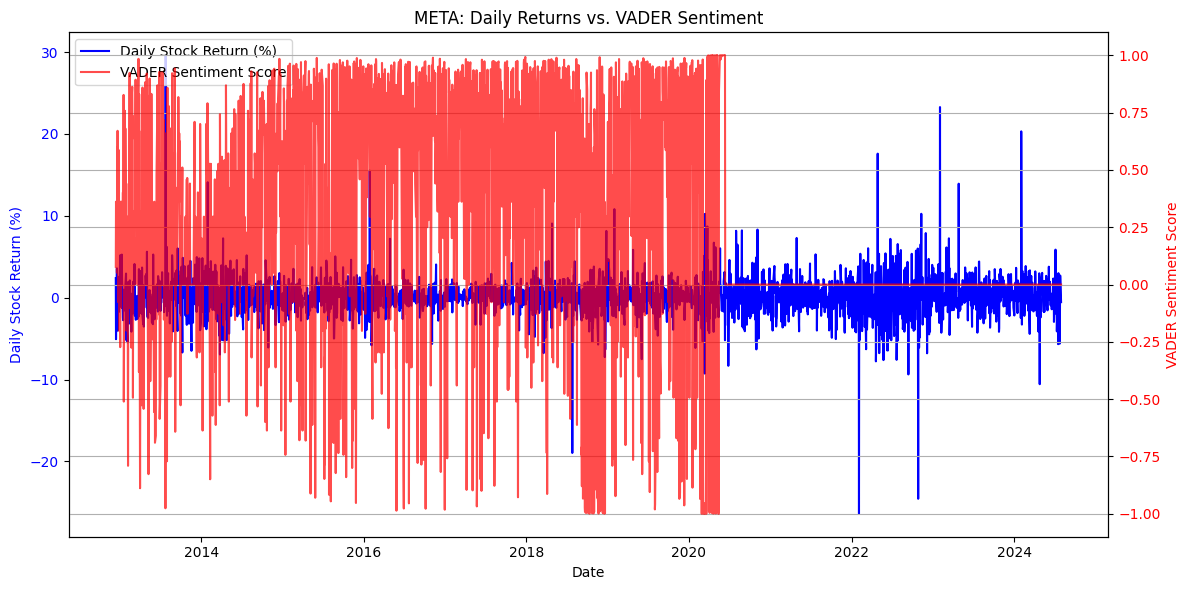


📊 Processing AAPL...
Loaded: ../Data/yfinance_data/AAPL_historical_data.csv

Date alignment and merging complete.
Daily stock returns calculated.

Columns before sentiment analysis: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends', 'Stock Splits', 'Headline', 'Daily_Return']
Sample data:            Headline
Date               
1980-12-15         
1980-12-16         
1980-12-17         
1980-12-18         
1980-12-19         

Performing sentiment analysis...
Sentiment analysis complete.

Columns after sentiment analysis: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends', 'Stock Splits', 'Headline', 'Daily_Return', 'TextBlob_Sentiment', 'VADER_Sentiment']
Correlation between TextBlob_Sentiment and Same-Day Daily_Return: -0.0004
Correlation between TextBlob_Sentiment (Lag 1) and Daily_Return: -0.0001
Correlation between VADER_Sentiment and Same-Day Daily_Return: 0.0085
Correlation between VADER_Sentiment (Lag 1) and Daily_Return: 0.0034


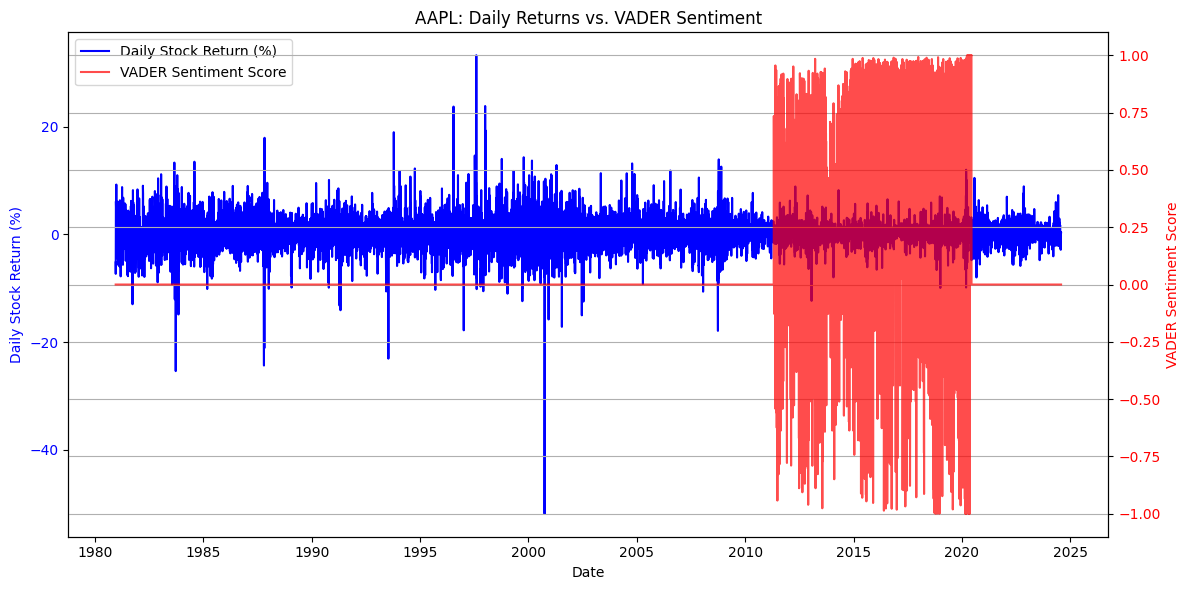


📊 Processing AMZN...
Loaded: ../Data/yfinance_data/AMZN_historical_data.csv

Date alignment and merging complete.
Daily stock returns calculated.

Columns before sentiment analysis: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends', 'Stock Splits', 'Headline', 'Daily_Return']
Sample data:            Headline
Date               
1997-05-16         
1997-05-19         
1997-05-20         
1997-05-21         
1997-05-22         

Performing sentiment analysis...
Sentiment analysis complete.

Columns after sentiment analysis: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends', 'Stock Splits', 'Headline', 'Daily_Return', 'TextBlob_Sentiment', 'VADER_Sentiment']
Correlation between TextBlob_Sentiment and Same-Day Daily_Return: -0.0063
Correlation between TextBlob_Sentiment (Lag 1) and Daily_Return: 0.0121
Correlation between VADER_Sentiment and Same-Day Daily_Return: 0.0073
Correlation between VADER_Sentiment (Lag 1) and Daily_Return: -0.0005


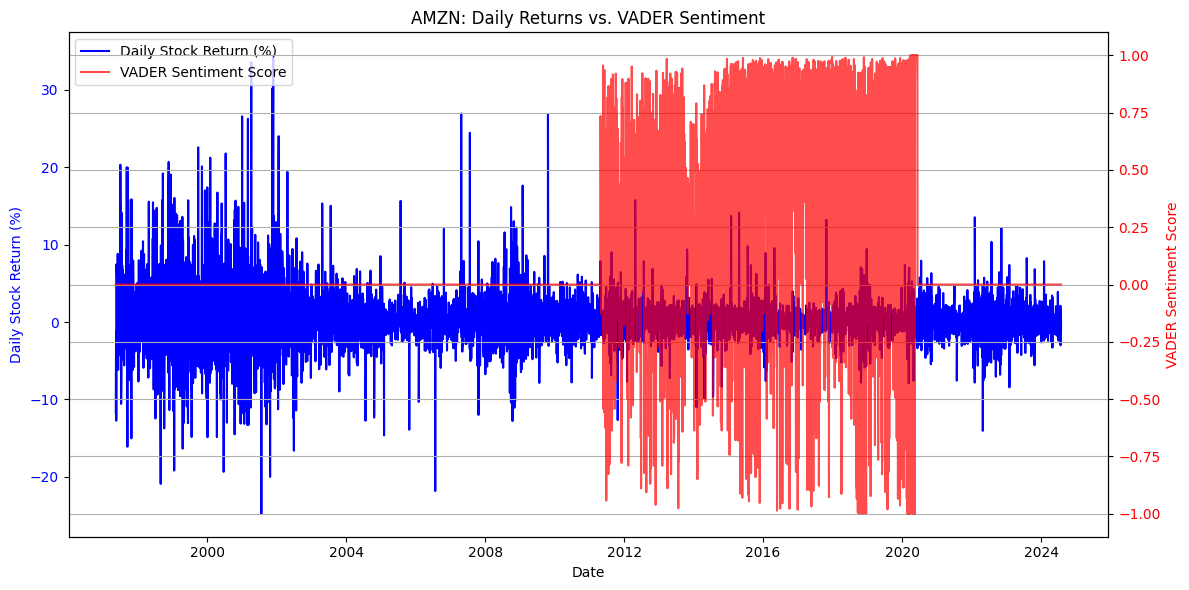


📊 Processing GOOG...
Loaded: ../Data/yfinance_data/GOOG_historical_data.csv

Date alignment and merging complete.
Daily stock returns calculated.

Columns before sentiment analysis: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends', 'Stock Splits', 'Headline', 'Daily_Return']
Sample data:            Headline
Date               
2004-08-20         
2004-08-23         
2004-08-24         
2004-08-25         
2004-08-26         

Performing sentiment analysis...
Sentiment analysis complete.

Columns after sentiment analysis: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends', 'Stock Splits', 'Headline', 'Daily_Return', 'TextBlob_Sentiment', 'VADER_Sentiment']
Correlation between TextBlob_Sentiment and Same-Day Daily_Return: -0.0047
Correlation between TextBlob_Sentiment (Lag 1) and Daily_Return: 0.0118
Correlation between VADER_Sentiment and Same-Day Daily_Return: 0.0145
Correlation between VADER_Sentiment (Lag 1) and Daily_Return: -0.0046


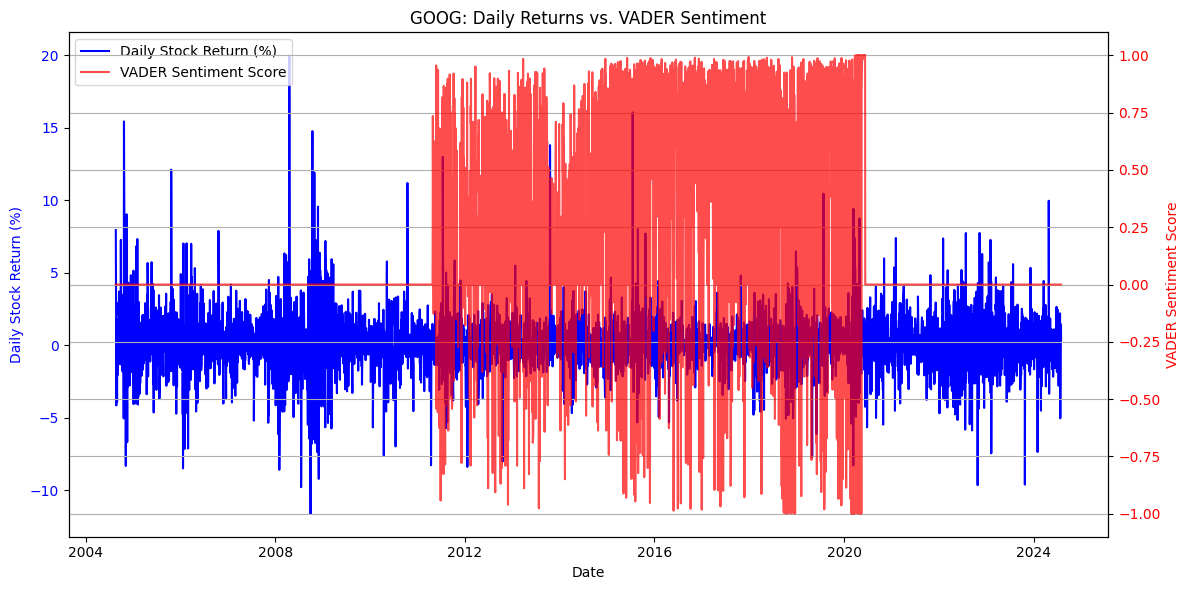


📊 Processing MSFT...
Loaded: ../Data/yfinance_data/MSFT_historical_data.csv

Date alignment and merging complete.
Daily stock returns calculated.

Columns before sentiment analysis: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends', 'Stock Splits', 'Headline', 'Daily_Return']
Sample data:            Headline
Date               
1986-03-14         
1986-03-17         
1986-03-18         
1986-03-19         
1986-03-20         

Performing sentiment analysis...
Sentiment analysis complete.

Columns after sentiment analysis: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends', 'Stock Splits', 'Headline', 'Daily_Return', 'TextBlob_Sentiment', 'VADER_Sentiment']
Correlation between TextBlob_Sentiment and Same-Day Daily_Return: -0.0042
Correlation between TextBlob_Sentiment (Lag 1) and Daily_Return: -0.0089
Correlation between VADER_Sentiment and Same-Day Daily_Return: 0.0080
Correlation between VADER_Sentiment (Lag 1) and Daily_Return: 0.0051


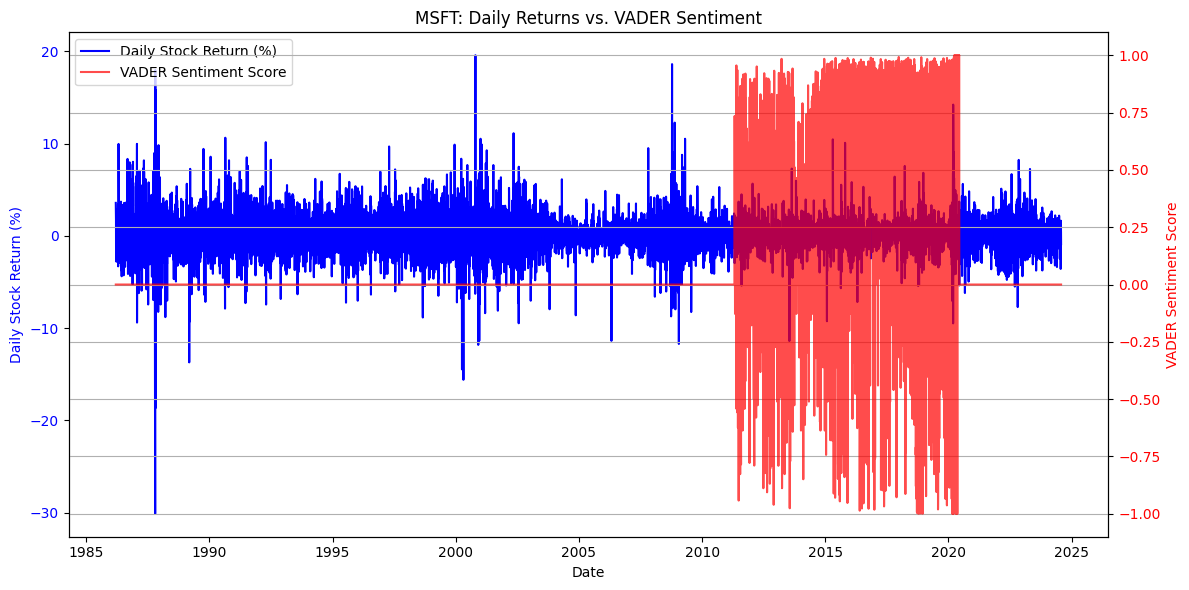


📊 Processing NVDA...
Loaded: ../Data/yfinance_data/NVDA_historical_data.csv

Date alignment and merging complete.
Daily stock returns calculated.

Columns before sentiment analysis: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends', 'Stock Splits', 'Headline', 'Daily_Return']
Sample data:            Headline
Date               
1999-01-25         
1999-01-26         
1999-01-27         
1999-01-28         
1999-01-29         

Performing sentiment analysis...
Sentiment analysis complete.

Columns after sentiment analysis: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends', 'Stock Splits', 'Headline', 'Daily_Return', 'TextBlob_Sentiment', 'VADER_Sentiment']
Correlation between TextBlob_Sentiment and Same-Day Daily_Return: 0.0015
Correlation between TextBlob_Sentiment (Lag 1) and Daily_Return: -0.0068
Correlation between VADER_Sentiment and Same-Day Daily_Return: 0.0293
Correlation between VADER_Sentiment (Lag 1) and Daily_Return: 0.0025


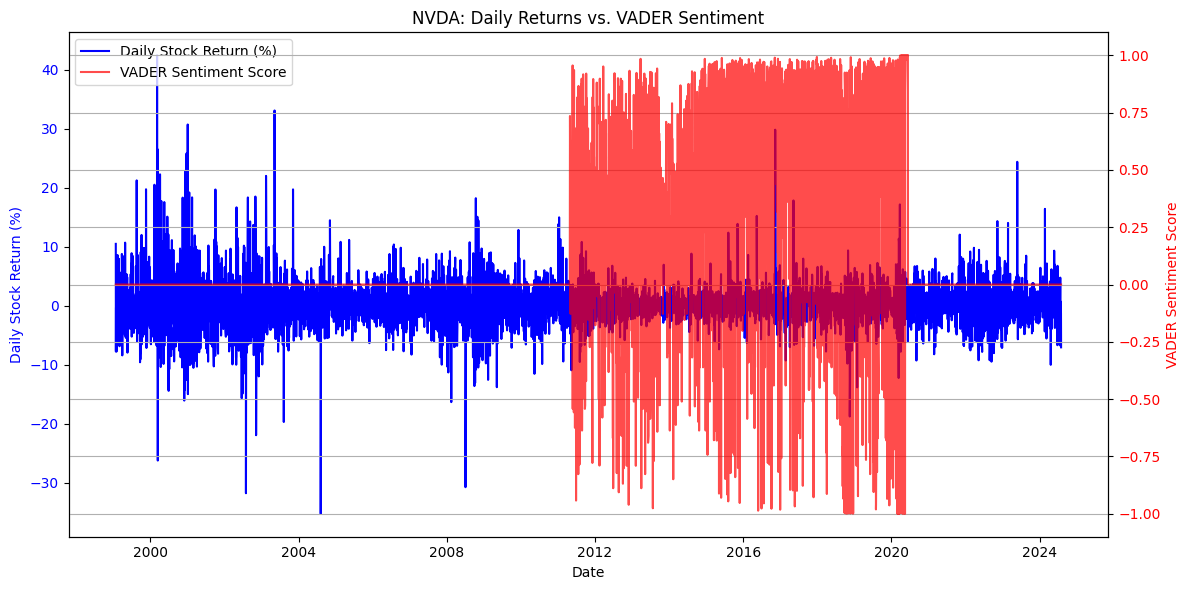


📊 Processing TSLA...
Loaded: ../Data/yfinance_data/TSLA_historical_data.csv

Date alignment and merging complete.
Daily stock returns calculated.

Columns before sentiment analysis: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends', 'Stock Splits', 'Headline', 'Daily_Return']
Sample data:            Headline
Date               
2010-06-30         
2010-07-01         
2010-07-02         
2010-07-06         
2010-07-07         

Performing sentiment analysis...
Sentiment analysis complete.

Columns after sentiment analysis: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends', 'Stock Splits', 'Headline', 'Daily_Return', 'TextBlob_Sentiment', 'VADER_Sentiment']
Correlation between TextBlob_Sentiment and Same-Day Daily_Return: 0.0094
Correlation between TextBlob_Sentiment (Lag 1) and Daily_Return: 0.0067
Correlation between VADER_Sentiment and Same-Day Daily_Return: 0.0052
Correlation between VADER_Sentiment (Lag 1) and Daily_Return: 0.0054


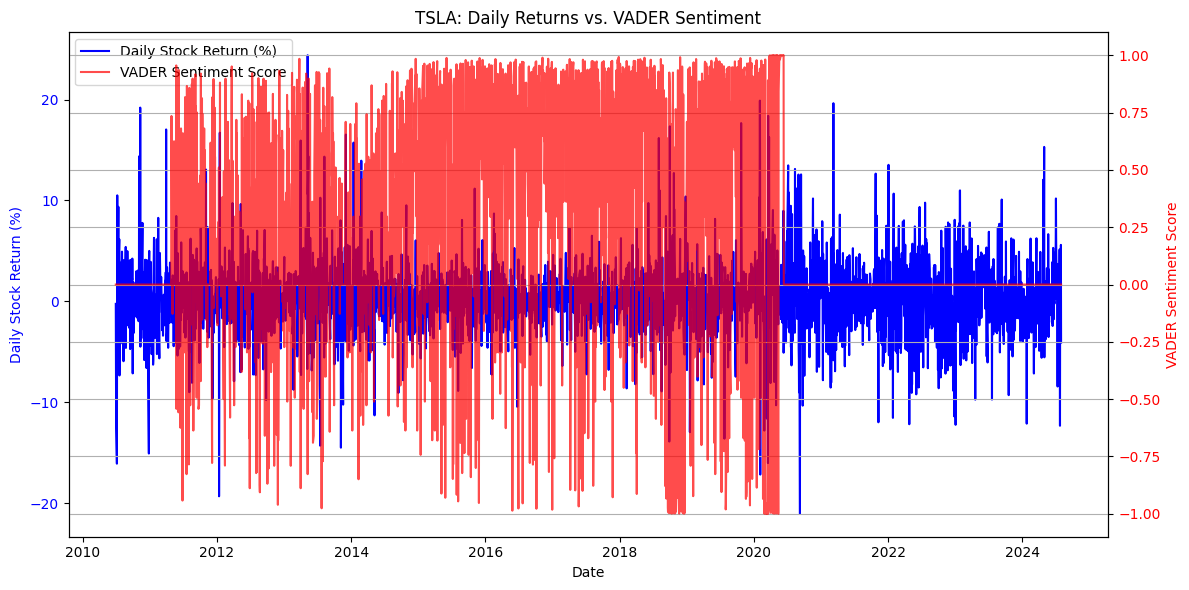


=== Market Sentiment Analysis Report ===
Key Performance Indicators (KPIs):


 Stock: META
Sample VADER Sentiment Scores (First 5 Headlines):
  'Apple to be Added to Several WisdomTree ETFs Apple to be Add...' → VADER Score: 0.08
  'IPO for Chart Acquisition Open at $10 Chart Acquisition Corp...' → VADER Score: 0.36
  'Obscure China ETF Bolstered by RQFII News PowerShares: No Lo...' → VADER Score: 0.05
  'Blackstone / GSO Senior Floating Rate Term Fund Declares Spe...' → VADER Score: 0.60
  'ETFs to Watch December 20, 2012 (CMF, LBJ, SLX) Amid Signs o...' → VADER Score: 0.38

 Correlation Strengths (Sentiment vs. Market Returns):
  ➤ TextBlob Sentiment:
    • TextBlob_Sentiment_SameDay_Corr: 0.0043
    • TextBlob_Sentiment_Lag1_Corr: 0.0200
  ➤ VADER Sentiment:
    • VADER_Sentiment_SameDay_Corr: 0.0153
    • VADER_Sentiment_Lag1_Corr: -0.0059

  SUMMARY STATISTICS:
  • Average Daily Return: 0.14%
  • Average TextBlob Sentiment: 0.04
  • Average VADER Sentiment: 0.23

--- Analysis Com

In [196]:
analyzer = MarketSentimentAnalysis(news_filepath, stock_filespath)
results = analyzer.run_analysis()

print("\n=== Market Sentiment Analysis Report ===")
print("Key Performance Indicators (KPIs):\n")

for stock_name, result in results.items():
    final_df = result['df']
    textblob_corrs = result['textblob_corrs']
    vader_corrs = result['vader_corrs']

    print(f"\n Stock: {stock_name}")
    
    # Show sample sentiment analysis results
    print("Sample VADER Sentiment Scores (First 5 Headlines):")
    for _, row in final_df.head().iterrows():
        headline = row['Headline'][:60] + ('...' if len(row['Headline']) > 60 else '')
        print(f"  '{headline}' → VADER Score: {row['VADER_Sentiment']:.2f}")

    print("\n Correlation Strengths (Sentiment vs. Market Returns):")

    print("  ➤ TextBlob Sentiment:")
    for key, value in textblob_corrs.items():
        print(f"    • {key}: {value:.4f}")

    print("  ➤ VADER Sentiment:")
    for key, value in vader_corrs.items():
        print(f"    • {key}: {value:.4f}")

    # Optional: Summary stats
    avg_return = final_df['Daily_Return'].mean()
    avg_tb_sent = final_df['TextBlob_Sentiment'].mean()    
    avg_vader_sent = final_df['VADER_Sentiment'].mean()

    print("\n  SUMMARY STATISTICS:")
    print(f"  • Average Daily Return: {avg_return:.2f}%")
    print(f"  • Average TextBlob Sentiment: {avg_tb_sent:.2f}")
    print(f"  • Average VADER Sentiment: {avg_vader_sent:.2f}")
    print("\n--- Analysis Complete for this stock ---\n")
